# Hochauflösende g-Spektrometrie mit einem Germanium-Detektor: Auswertung der Energiespektren bekannter Nuklide

## Radium 226, Radium Folgeprodukte  
$$
\begin{align}
    ^{226}_{80}\text{Ra} &\longrightarrow ^{222}_{86}\text{Rn} + \alpha (+ \gamma_{186 keV}) \\
    ^{222}_{86}\text{Rn} &\longrightarrow ^{218}_{84}\text{Po} + \alpha \\
    ^{218}_{84}\text{Po} &\longrightarrow ^{214}_{82}\text{Pb} + \alpha \\
    ^{214}_{82}\text{Pb} &\longrightarrow ^{214}_{83}\text{Bi} + \beta^- (+\gamma_{352, 295, 242, 53 keV} \\
    ^{214}_{83}\text{Bi} &\longrightarrow ^{214}_{84}\text{Po} + \beta^- (+\gamma_{609 keV} \\
    ...
\end{align}
$$

## Aufbau

<img src="./footage/germanium_detector.jpg" alt="Drawing" style="width: 500px;"/>  
<img src="./footage/mca_preamp_shaper.jpg" alt="Drawing" style="width: 300px;"/>  

Links: Messkammer mit Germaniumdetektor. Rechts: Multi-Channel-Analyzer mit Vorverstärker.

## Importe

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "svg" # crisper plots
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import lmfit as lm
from scipy.signal import find_peaks

In [122]:
# Opening the data iterating over all the files found int eh cell above
sample_files = [
    "./messdaten/Ra-226-Spektren_V13/Ra-226_500ns_grosseTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_1us_grosseTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_2us_grosseTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_4us_grosseTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_2us_mittlereTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_4us_mittlereTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_4us_geringeTotzeit.RPT"]
spl_lst = []
for file in sample_files:
    with open(file, newline='', encoding='utf-8') as path:
        frame = pd.read_csv(path, delimiter=';')
        frame.columns = [col.strip() for col in frame] # stupid whitespaces t(-_-t)
        spl_lst.append(frame)
        del frame

g500ns = spl_lst[0]
g1us = spl_lst[1]
g2us = spl_lst[2]
g4us = spl_lst[3]
m2us = spl_lst[4]
m4us = spl_lst[5]
l4us = spl_lst[6]

In [ ]:
# Nightowl mode
plt.style.use("default")
plt.style.use("dark_background")
cm = 1/2.54 # inch to cm, metric like brrr
size = 60

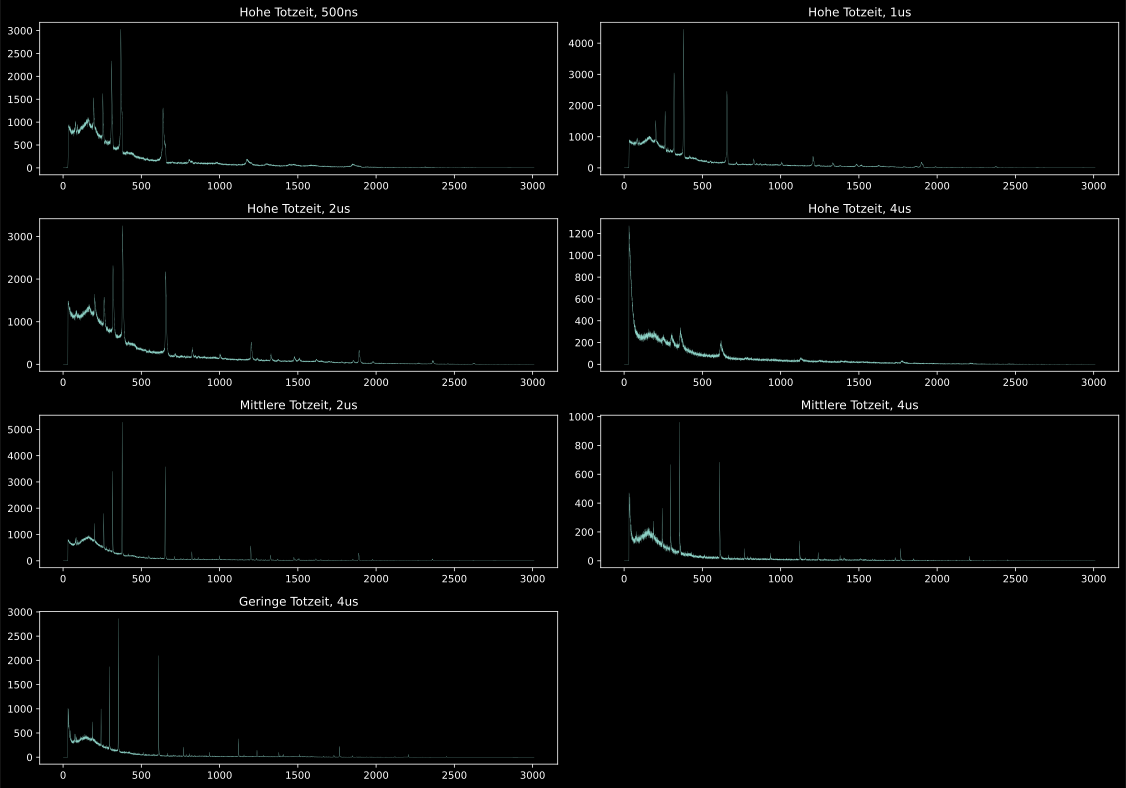

In [136]:
titles = ["Hohe Totzeit, 500ns", "Hohe Totzeit, 1us", "Hohe Totzeit, 2us","Hohe Totzeit, 4us","Mittlere Totzeit, 2us","Mittlere Totzeit, 4us","Geringe Totzeit, 4us"]
fig, ax = plt.subplots(4,2,figsize=(40*cm, 50*(9/16)*cm))
row, col, k = 4, 2, 0
for i in range(row):
	for j in range(col):
		if k == 7:
			ax[-1,-1].axis('off')
			break
		ax[i,j].plot(spl_lst[k]["Energie(keV)"], spl_lst[k]["Impulse"], linewidth=.2)
		ax[i,j].set_title(titles[k])
		k += 1
plt.tight_layout()

## Radium 226, Radium Folgeprodukte  
$$
\begin{align}
    ^{226}_{80}\text{Ra} &\longrightarrow ^{222}_{86}\text{Rn} + \alpha (+ \gamma_{186 keV}) \\
    ^{222}_{86}\text{Rn} &\longrightarrow ^{218}_{84}\text{Po} + \alpha \\
    ^{218}_{84}\text{Po} &\longrightarrow ^{214}_{82}\text{Pb} + \alpha \\
    ^{214}_{82}\text{Pb} &\longrightarrow ^{214}_{83}\text{Bi} + \beta^- (+ \gamma_{352, 295, 242, 53 keV}) \\
    ^{214}_{83}\text{Bi} &\longrightarrow ^{214}_{84}\text{Po} + \beta^- (+ \gamma_{609 keV}) \\
    ...
\end{align}
$$

|Radionuklid|$t_{1/2}$|
|----|-----|
|Ra226|1620a|
|Rn222|3,82d|
|Po218|3,05m|
|Pb214|26,8m|
|Bi214|19,7m|

[  435   448   509  1084  1409  1718  2049  3548  4474  6525  7212 10279]


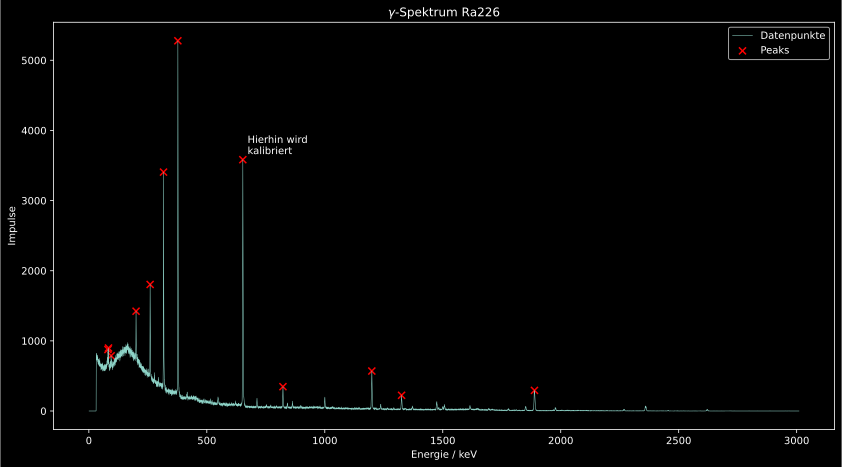

In [138]:
xarr = m2us["Energie(keV)"]
yarr = m2us["Impulse"]

fig, ax = plt.subplots(figsize=(30*cm, 30*(9/16)*cm))
peaks, _ = find_peaks(yarr, prominence=(180, None), wlen=80)
print(peaks)
pox = xarr.iloc[peaks[7]]
poy = yarr.iloc[peaks[7]]
ax.scatter(xarr.iloc[peaks], yarr.iloc[peaks], marker='x', s=50, color='r', label="Peaks")
ax.annotate("Hierhin wird\nkalibriert", (pox, poy), (pox+20, poy+50), verticalalignment='bottom')
ax.plot(xarr, yarr, '-', linewidth=.5, label="Datenpunkte")
ax.set_title("$\gamma$-Spektrum Ra226")
ax.set_xlabel("Energie / keV")
ax.set_ylabel("Impulse")
ax.legend()
plt.tight_layout()
ecoeff = 609 / pox

[75.50017889745536, 77.728141757271, 88.18216342569856, 186.72456411462613, 242.42242247840778, 295.3782301333801, 352.1043575129653, 609.0, 767.6960914545244, 1119.192390077665, 1236.9291457282582, 1762.5455710429758]


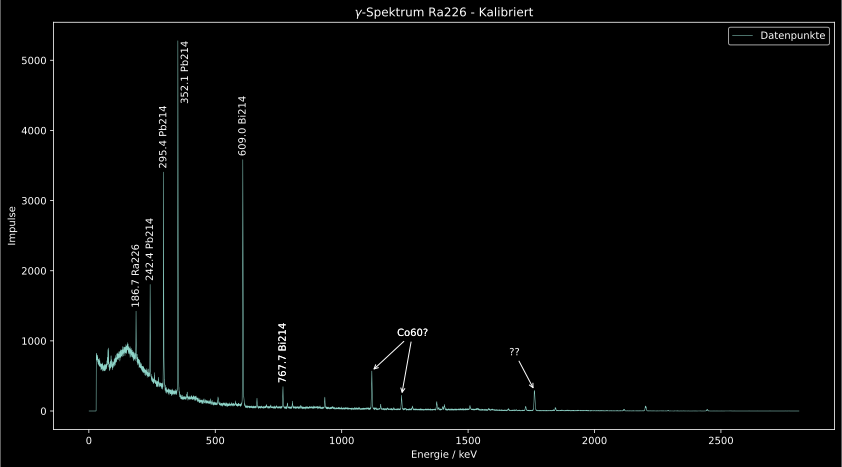

In [150]:
xarr = m2us["Energie(keV)"] * ecoeff
yarr = m2us["Impulse"]

fig, ax = plt.subplots(figsize=(30*cm, 30*(9/16)*cm))
peaks, _ = find_peaks(yarr, prominence=(180, None), wlen=80)
xpeaks = xarr.iloc[peaks].tolist()
ypeaks= yarr.iloc[peaks].tolist()
print(xpeaks)
ax.annotate("??", (xpeaks[11], ypeaks[11]), (xpeaks[11]-100, ypeaks[11]+500), arrowprops={'arrowstyle': '->'})
ax.annotate("Co60?", (xpeaks[10], ypeaks[10]), (xpeaks[9]+100, ypeaks[9]+500), arrowprops={'arrowstyle': '->'})
ax.annotate("Co60?", (xpeaks[9], ypeaks[9]), (xpeaks[9]+100, ypeaks[9]+500), arrowprops={'arrowstyle': '->'})
ax.annotate("{} Bi214".format(round(xpeaks[8], 1)), (xpeaks[8], ypeaks[8]), (xpeaks[8], ypeaks[8]+50), verticalalignment='bottom', horizontalalignment='center', rotation=90)
ax.annotate("{} Bi214".format(round(xpeaks[8], 1)), (xpeaks[8], ypeaks[8]), (xpeaks[8], ypeaks[8]+50), verticalalignment='bottom', horizontalalignment='center', rotation=90)
ax.annotate("{} Bi214".format(round(xpeaks[7], 1)), (xpeaks[7], ypeaks[7]), (xpeaks[7], ypeaks[7]+50), verticalalignment='bottom', horizontalalignment='center', rotation=90)
ax.annotate("{} Pb214".format(round(xpeaks[6], 1)), (xpeaks[6], ypeaks[6]), (xpeaks[6]+10, ypeaks[6]), verticalalignment='top', horizontalalignment='left', rotation=90)
ax.annotate("{} Pb214".format(round(xpeaks[5], 1)), (xpeaks[5], ypeaks[5]), (xpeaks[5], ypeaks[5]+50), verticalalignment='bottom', horizontalalignment='center', rotation=90)
ax.annotate("{} Pb214".format(round(xpeaks[4], 1)), (xpeaks[4], ypeaks[4]), (xpeaks[4], ypeaks[4]+50), verticalalignment='bottom', horizontalalignment='center', rotation=90)
ax.annotate("{} Ra226".format(round(xpeaks[3], 1)), (xpeaks[3], ypeaks[3]), (xpeaks[3], ypeaks[3]+50), verticalalignment='bottom', horizontalalignment='center', rotation=90)
ax.plot(xarr, yarr, '-', linewidth=.5, label="Datenpunkte")
ax.set_title("$\gamma$-Spektrum Ra226 - Kalibriert")
ax.set_xlabel("Energie / keV")
ax.set_ylabel("Impulse")
ax.legend()
plt.tight_layout()